# 3 - Euler-Maruyama method

Now we have reviewed basic concepts about probability and sampling distributions using `numpy`, we can delve into the technical core of this project. The objective of this notebook is to introduce the Euler-Maruyama (EM) method to numerically solve a Stochastic differential equation (SDE). Before presenting the numerical method, we provide a brief explanation of what is an SDE and what are its main components. We then describe the Brownian motion and its relationship with Gaussian normal distributions. The Brownian motion is the fundamental building block to understand and solve SDEs. We conclude explaining the EM method and how to implement it using `numpy` capabilities.

## Contents
### [A. Stochastic differential equations](#sde)
### [B. Brownian Motion](#brownian)
### [C. Euler-Maruyama method](#em)

<a id="sde"></a>
### A. Stochastic differential equations

An SDE is a mathematical equation describing the dynamics of a system or process subject to deterministic and random influences. Specifically, it formulates the time-evolution equation of variables with inherent randomness. By seamlessly incorporating random terms, SDEs offer a powerful framework for analysing and understanding random variable behaviour. As a result, SDEs find wide-ranging applicability in fields such as biology, finance and physics.

Although there are different types of SDEs, we restrict our attention to the following type of SDE, so-called Itô SDE. Considering that $X_t$ represents the variable we are interested in, at time $t$, its related SDE is written in the form of:

\begin{align}
dX_{t} = \mu(X_t, t)dt + \sigma(X_t, t) dW_t.
\end{align}

Now, we explain each component of the equation above:

* $dX_t$ is the **differential** of $X_t$, i.e., a small (infinitesimal) change of $X_t$. It represents how much $X_t$ changes when $t$ varies a very small quantity, namely $dt$, a differential of time.


* $\mu(X_t, t)dt$ is the **drift** term. It represents the deterministic force driving the expected or average rate of change in $X_t$ at time $t$. In general, the drift coefficient $\mu(\cdot)$ can be a function of the process value $X_t$ and the current time $t$ as represented here, or it can be a constant, $\mu(X_t, t) = \mu$. As we will see later, this term informs about the trend behaviour of $X$ over time.


* $\sigma(X_t, t)dW_t$ is the **diffusion** term. It represents the stochastic part of the equation, introducing the random behaviour in $X_t$. The term $\sigma(X_t, t)$ is called the diffusion coefficient and it is inherently related to the volatility or uncertainty evolution of the variable $X_t$ at time $t$. Like the drift coefficient, the diffusion coefficient can be a function of the process value $X_t$ and be time-dependent $t$ or it can be a constant $\sigma(X_t, t) = \sigma$. $W_t$ is a Wiener process, so-called **Brownian motion**. It is responsible for the random fluctuation of the variable $X$ over time. For this purpose, $W_t$ injects random noise in the time-evolution equation of $X_t$. We will provide a detailed explanation of the Brownian motion and its implications in the next subsection. Now, we can think of the Brownian motion as a noise generator that follows a Gaussian distribution $W_t \sim \mathcal{N(0, t)}$.

For a more comprehensive understanding of stochastic differential equations, we recommend referring to this [book](https://link.springer.com/book/10.1007/978-3-662-12616-5).

<a id="brownian"></a>
### B. Brownian motion

In the previous section, we mentioned that $W_t$ is a Wiener process or Brownian motion. The aim of this section is to explain the concept of Brownian motion, its significance in generating random solutions of SDEs, and its implications. While our explanation focuses on intuition rather than rigorous mathematical formalism, it provides an accesible understanding of Brownian motion. For a more detailed explanation of Brownian motion or Wiener process, the reader can refer to these two sources: [link 1](https://www.wiley.com/en-sg/Brownian+Motion+Calculus-p-9780470021705) and [link 2](https://www.amazon.com/Introduction-Stochastic-Processes-Physics-Paperback/dp/080186867X).

Brownian motion is essentially a random process that was first observed by the botanist Robert Brown in 1827. It describes the erratic and irregular trajectories of small pollen grains suspended in water. This random phenomenon remained unexplained for many years. In the early 20th century, Albert Einstein, Marian Smoluchowski, and Paul Langevin independtly developed a set of physical explanations of Brown's observations. Specifically, the work of Paul Langevin in 1908 ["On the Theory of Brownian Motion"](https://www.physik.uni-augsburg.de/theo1/hanggi/History/Langevin1908.pdf) is considered the foundation of SDEs. This publication contains the first appearance of an SDE describing the displacement of individual particles inmersed in a fluid.

Instead of following the physical reasoning behind Langevin's work, we adopt an intuitive approach to define Brownian motion by considering a symmetric random walk. First, we divide the real half-line $[0, \infty)$ into small non-overlapping intervals of length $\delta$, so that the $k$th interval is $((k-1)\delta, \, k\delta]$. For each interval we toss a unbiased coin *independently* and we define the following random variable:

\begin{align}
X_k = \left\{
\begin{array}{l l}
\sqrt{\delta} & \quad \textrm{if the coin toss is heads} \\
& \quad \\
-\sqrt{\delta} & \quad \textrm{if the coin toss is tails}
\end{array} \right.
\end{align}

This means that $P\left( X_k = \sqrt{\delta} \right) = 0.5$ and $P\left( X_k = -\sqrt{\delta} \right) = 0.5$, where $\mathbb{E}[X_k] = 0$ and $Var(X_k) = \delta$. We define now a process $W_t$, with $t=n\delta$ as follows:

\begin{align}
W_t = W_{(n\delta)} = \sum\limits_{k=1}^{n} X_k,
\end{align}

with $W_0 = 0$ as the initial condition. This means that $W_t$ is a process accumulating all coin tosses results up to time $t$. By utilising statistical properties of *independent* sums of random variables and the central limit theorem, whose explanation is beyond the scope of this project, we obtain:

\begin{align}
&\mathbb{E}[W_t] = \sum\limits_{k=1}^{n} \mathbb{E}[X_k] = 0 \quad Var(W_t) = \sum\limits_{k=1}^{n} Var(X_k) = n Var(X_k) = n \delta = t  \\
&\text{if } t \in (0, \infty) \text{ and } n \rightarrow \infty, \delta \text{ goes to } 0  \implies  W_t \sim \mathcal{N}(0, t).
\end{align}

The process $W_t$ is called a standard Brownian motion because it follows a normal random variable. Let us write a small code to simulate this Brownian motion, $W_t$, in order to understand its behaviour.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# First, we define the random variable x_k
def get_x_k(delta: float):
    coin = np.random.rand()  # coin toss
    if coin < 0.5:  # equivalent to heads
        return np.sqrt(delta)
    else:  # equivalent to tails
        return (-1)*np.sqrt(delta)

# We define the process W_t for a number of steps n and length delta
def compute_w_t(n: int, delta:float):
    w_t = np.zeros(n)
    w_t[0] = 0  # recall the initial condition, by definition W_0 = 0
    for i in range(1, n):
        w_t[i] = get_x_k(delta=delta)
        
    # Apply the cumulative sum to represent W_t at time t
    w_t = np.cumsum(w_t)
    
    return w_t 

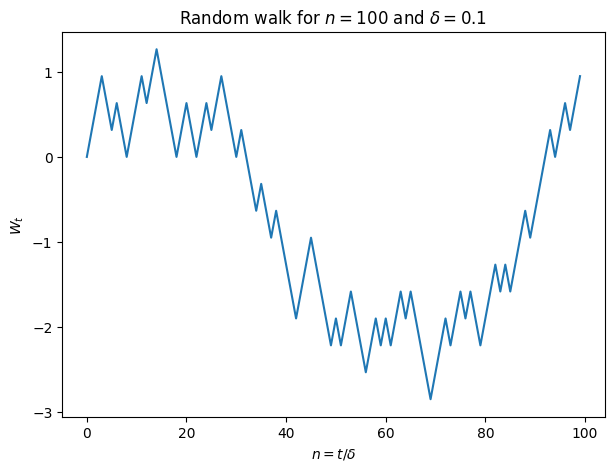

In [3]:
# Compute the process and plot the result
w_t = compute_w_t(n=100, delta=0.1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(w_t)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"Random walk for $n=100$ and $\delta=0.1$")
plt.show()

We have obtained our first Brownian motion, which is simply a random walk. However, it does not resemble an erratic and fluctuating walk. Remember that as $n \rightarrow \infty$, $\delta$ goes to $0$, we meet the conditions to obtain a proper Brownian motion. So, let us repeat the random walk while adjusting $n, \delta$.

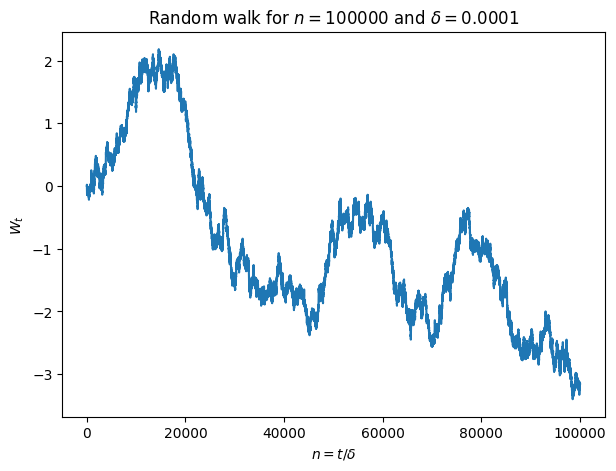

In [4]:
w_t = compute_w_t(n=100_000, delta=0.0001)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(w_t)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"Random walk for $n=100000$ and $\delta=0.0001$")
plt.show()

This looks much more like a genuine random walk! However, since we are only using a fair coin toss with equal probabilities for heads and tails, where does the random normal behavior come into play here? To illustrate the connection of our random walk (Brownian motion) with the normal random variable, we must consider an ensemble of random walks. Let us code it!

In [5]:
# Define the random variable x_k over multiple realisations
def get_multiple_x_k(delta: float, size: int):
    coins = np.random.rand(size)  # coin toss
    result = np.ones(size) * (-1)**(coins < 0.5) * np.sqrt(delta)  # (-1)**True = -1; (-1)**False = 1
    return result

def compute_multiple_w_t(n: int, delta:float, size: int):
    w_t = np.zeros(shape=(n, size))
    w_t[0, :] = 0  # recall the initial condition, by definition W_0 = 0
    for i in range(1, n):
        w_t[i, :] = get_multiple_x_k(delta=delta, size=size)
        
    # Apply the cumulative sum to represent W_t at time t
    w_t = np.cumsum(w_t, axis=0)
    
    return w_t 

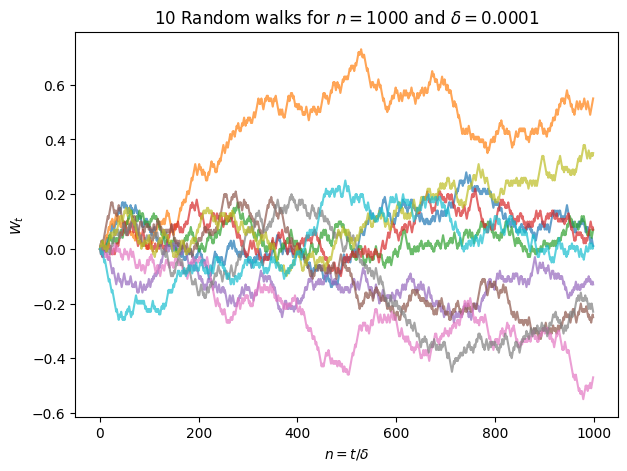

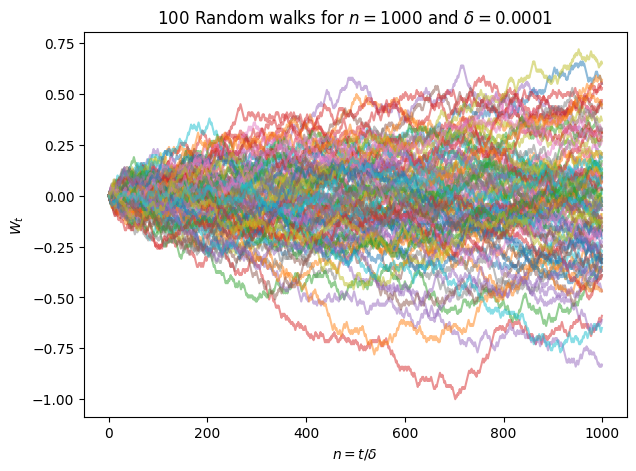

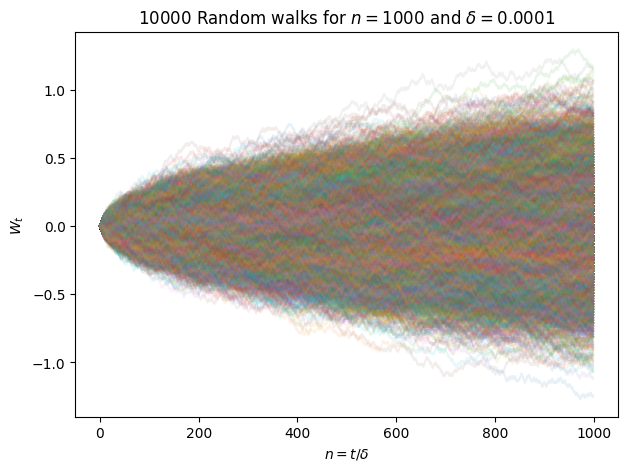

In [6]:
delta = 0.0001
multiple_10_w_t = compute_multiple_w_t(n=1000, delta=delta, size=10)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10_w_t, alpha=.7)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

multiple_100_w_t = compute_multiple_w_t(n=1000, delta=delta, size=100)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_100_w_t, alpha=.5)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"100 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

multiple_10000_w_t = compute_multiple_w_t(n=1000, delta=delta, size=10_000)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")
plt.show()

Now, we start to see a pattern in the ensemble of random walks. According to the definition provided above, $W_t \sim \mathcal{N}(0, t)$. This implies that the generated random walks must approximate to a Gaussian normal distribution with mean 0 and variance $t$ at each time $t$. Let us check this statement by analysing the random walk results at three different time steps, namely $t_1=100\delta$, $t_2=500\delta$, and $t_3=1000\delta$. We will compare the empirical distribution (blue histograms) with the theoretical probability density function (PDF) of a normal random variable (green line).   

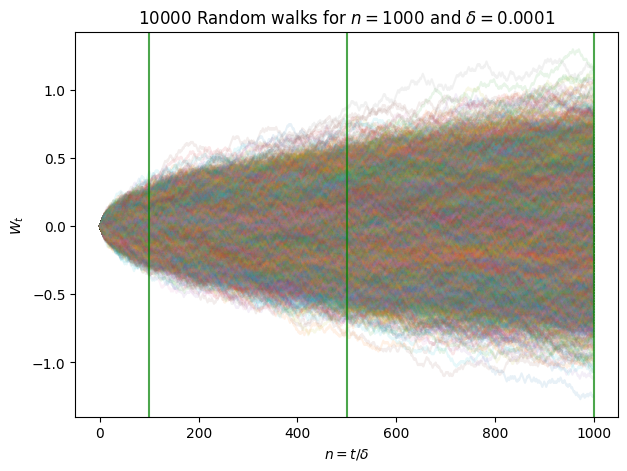

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")
ax.axvline(x=100, ymin=0, ymax=1, color="green", alpha=0.7)
ax.axvline(x=500, ymin=0, ymax=1, color="green", alpha=0.7)
ax.axvline(x=1000, ymin=0, ymax=1, color="green", alpha=0.7)
plt.show()

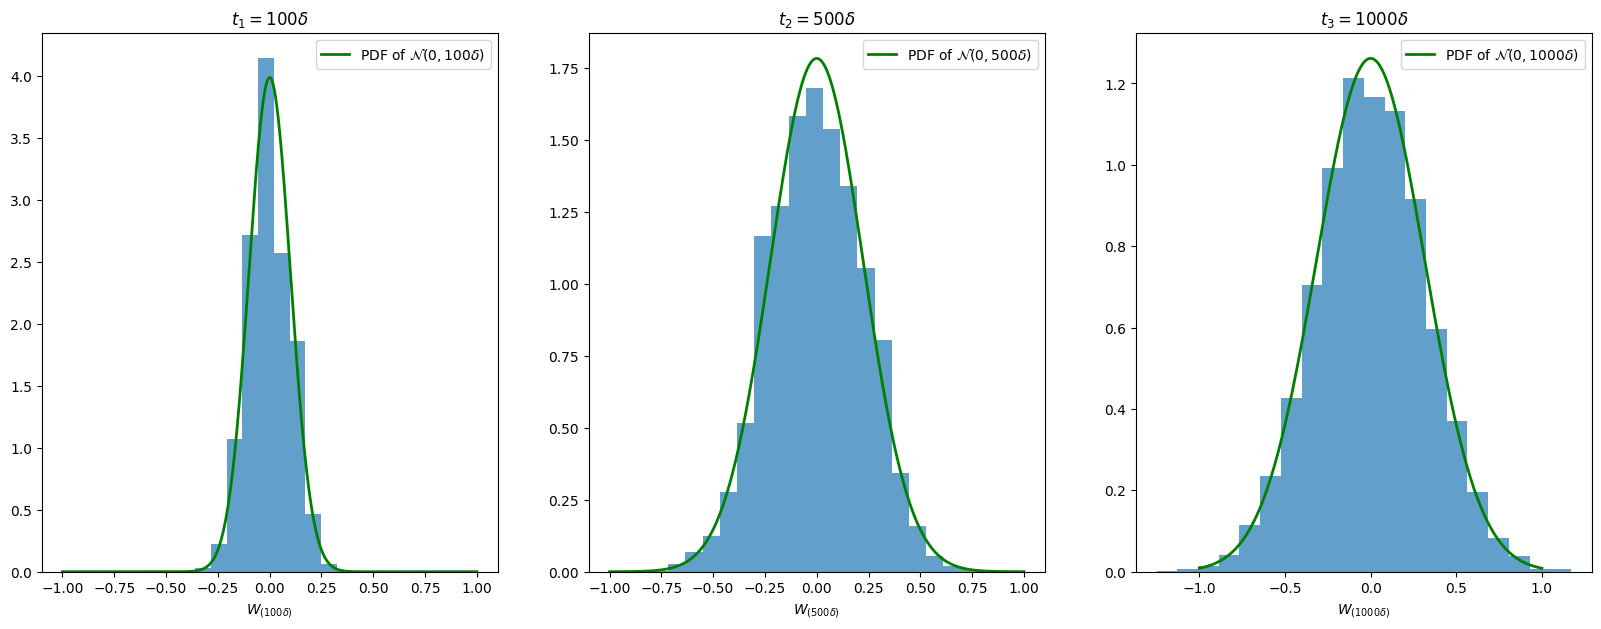

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 7))

x = np.linspace(-1, 1, 500)
var_100 = 100*delta
normal_function_100 = 1/np.sqrt(2*np.pi*var_100)*np.exp(-x**2/(2*var_100))
ax0.hist(multiple_10000_w_t[100, :], alpha=.7, density=True)
ax0.plot(x, normal_function_100, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  100\delta)$")
ax0.set_xlabel(r"$W_{(100\delta)}$")
ax0.set_title(r"$t_1=100\delta$")
ax0.legend()

var_500 = 500*delta
normal_function_500 = 1/np.sqrt(2*np.pi*var_500)*np.exp(-x**2/(2*var_500))
ax1.hist(multiple_10000_w_t[500, :], alpha=.7, density=True, bins=20)
ax1.plot(x, normal_function_500, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  500\delta)$")
ax1.set_xlabel(r"$W_{(500\delta)}$")
ax1.set_title(r"$t_2=500\delta$")
ax1.legend()

var_1000 = 1000*delta
normal_function_1000 = 1/np.sqrt(2*np.pi*var_1000)*np.exp(-x**2/(2*var_1000))
ax2.hist(multiple_10000_w_t[1000-1, :], alpha=.7, density=True, bins=20)
ax2.plot(x, normal_function_1000, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  1000\delta)$")
ax2.set_xlabel(r"$W_{(1000\delta)}$")
ax2.set_title(r"$t_3=1000\delta$")
ax2.legend()

plt.show()

We can observe how, for each time step $t$, the samples obtained from the random walks approximate a Gaussian normal distribution $\mathcal{N}(0, t)$.

As an additional example to illustrate the relationship between Brownian motion and the Gaussian distribution, we plot the time-evolution of the 99% region probability of the values of the random walk. Based on the properties of the normal distribution, we know that approximately 99.7% of the values drawn from a normal distribution lie within 3 standard deviations with respect to the mean value, i.e., $[\mu - 3\sigma, \mu + 3\sigma]$. This means that for a standard normal distribution, $\mathcal{N}(0, 1)$, there is ~99.7% probabilty of obtaining a random sample within $[0 - 3 \cdot 1, 0 + 3 \cdot 1] = [-3, 3]$. By considering both extremes of the 99% interval at every time step of the random walk, we can generate the following graph.

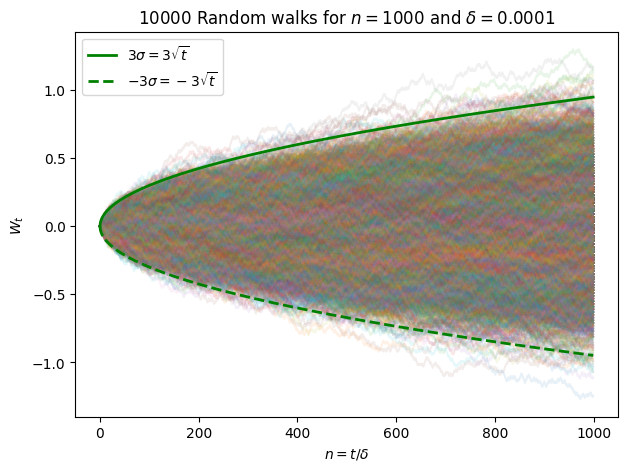

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(multiple_10000_w_t, alpha=.1)
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$W_t$")
ax.set_title(f"10000 Random walks for $n=1000$ and $\delta=0.0001$")

# Since at every time step, t, W_t follows N(0, t), 
# the standard deviation at t=n*delta is sqrt(t) = sqrt(n*delta)
std = np.sqrt(np.arange(0, 1_000) * delta)

ax.plot(3*std, color="green", lw=2, label=r"$3\sigma = 3 \sqrt{t}$")
ax.plot(-3*std, color="green", lw=2, ls='--', label=r"$-3\sigma = -3 \sqrt{t}$")
ax.legend()

plt.show()

The area enclosed by the green lines represents the 99% region probability. This indicates that there is a 99% likelihood of the random walk falling within these boundaries. We can observe that, as time increases (n increases in this example), the 99% probability interval also expands. This means that our uncertainty, reflected here as the random walk dispersion, increases as time evolves. Note that fo $\mathcal{N}(0, t)$, the variance increases linearly with time, $\propto t$, while the standard deviation increases proportionally to the square root of time, $\propto \sqrt{t}$ as shown in the figure above.

The inherent simplicity and subtle nature of Brownian motion make it a really powerful tool to model stochastic processes and capture the growing uncertainty over time in the form of noise injection. This behaviour resembles many natural and social phenomena, where our confidence in predicting future outcomes diminishes as the time horizon lengthens.

So far, we have dealt with simple Brownian motion, $W_t \sim \mathcal{N}(0, t)$. This process assumes that the initial condition is zero and and the probability of moving upward or downward is equal, as defined by our intuitive coin toss analogy. However, if we have a specific reason to beleive that our process should follow a deterministic time-evolution, we can effortlessly incorporate a standard Brownian motion on top of the deterministic function. Let us see a couple of examples.

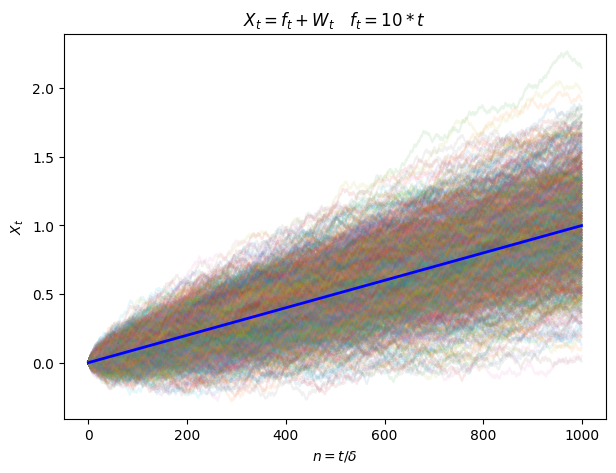

In [17]:
# A simple linear time-dependent function
# f = 10*t
f = 10 * np.arange(0, 1_000) * delta 
x = multiple_10000_w_t[:, :1000] + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = 10*t$")
plt.show()

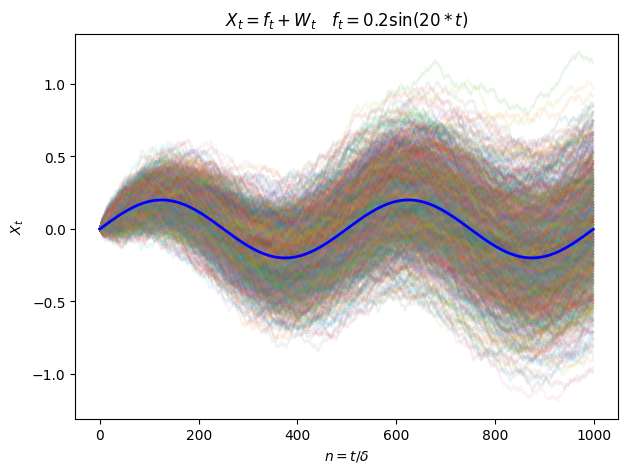

In [18]:
# An oscillating signal
# f = 0.2*sin(20*t)
f = 0.2*np.sin(np.arange(0, 1_000) * delta * 2*np.pi * 20)
x = multiple_10000_w_t[:, :1000] + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = 0.2\sin(20*t)$")
plt.show()

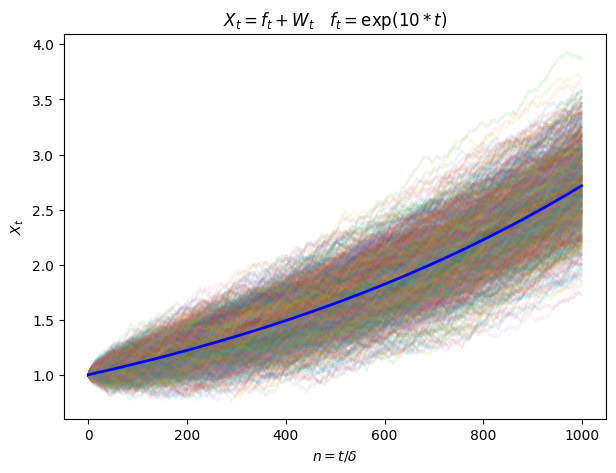

In [19]:
# An exponential signal
# f = exp(10*t)
f = np.exp(np.arange(0, 1_000) * delta * 10)
x = multiple_10000_w_t[:, :1000] + f.reshape(-1, 1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, alpha=.1)
ax.plot(f, lw=2, color="blue")
ax.set_xlabel(r"$n=t/\delta$")
ax.set_ylabel(r"$X_t$")
ax.set_title(f"$X_t = f_t + W_t \quad f_t = \exp(10*t)$")
plt.show()

These examples demonstrate the simplicity of building random functions by incorporating noise in the form of Brownian motion into a deterministic function.  It is important to note that in these illustrations, we have assumed complete independence between the Brownian paths and the deterministic function. In other words, the stochastic term is not influenced by the process value $X_t$. 

Another important property of Brownian motion is that its increments also follow a Gaussian random distribution. Let us explain this with an example.

Let us consider the values of the Brownian motion we have generated at two different instant, namely $t_a = 700\delta$ and $t_b = 900\delta$. From previous comments, we showed that the samples at each different instant follows a normal distribution.

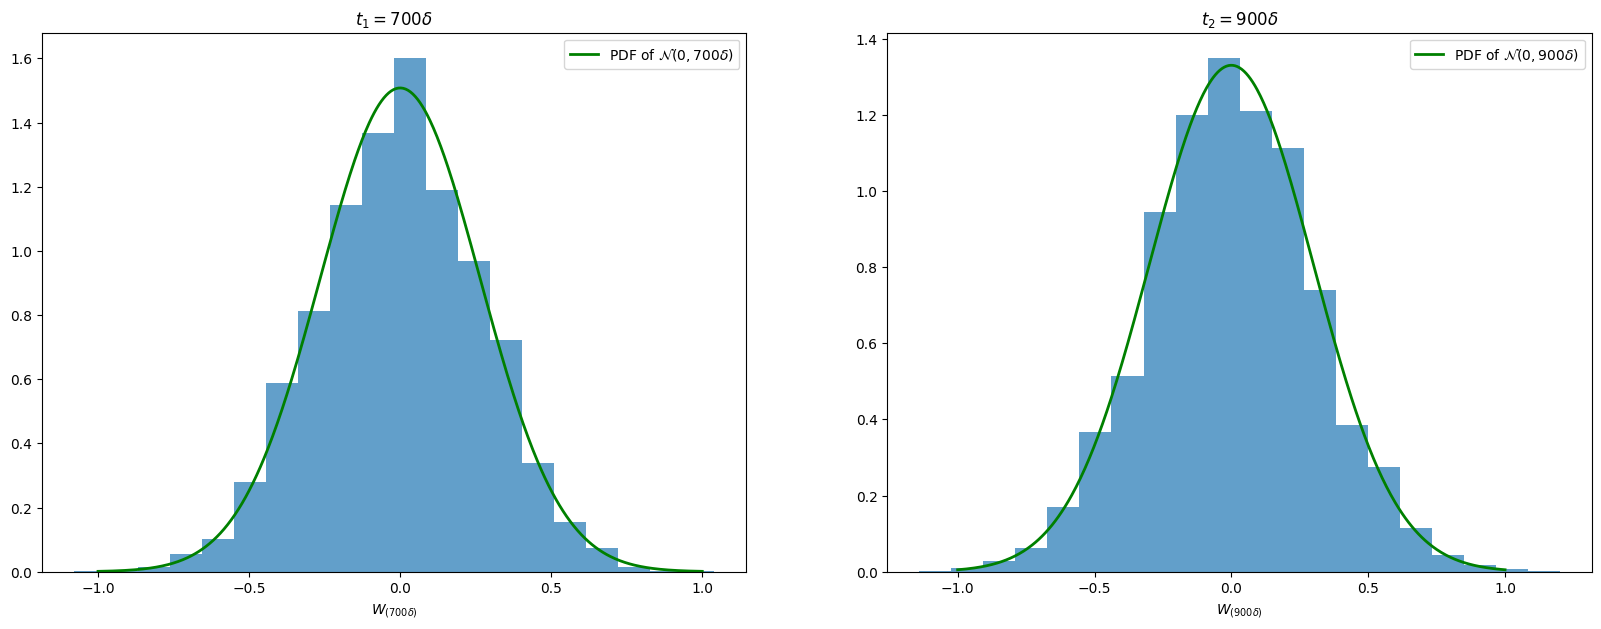

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))

x = np.linspace(-1, 1, 500)
var_700 = 700*delta
normal_function_700 = 1/np.sqrt(2*np.pi*var_700)*np.exp(-x**2/(2*var_700))
ax0.hist(multiple_10000_w_t[700, :], alpha=.7, density=True, bins=20)
ax0.plot(x, normal_function_700, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  700\delta)$")
ax0.set_xlabel(r"$W_{(700\delta)}$")
ax0.set_title(r"$t_1=700\delta$")
ax0.legend()

var_900 = 900*delta
normal_function_900 = 1/np.sqrt(2*np.pi*var_900)*np.exp(-x**2/(2*var_900))
ax1.hist(multiple_10000_w_t[900, :], alpha=.7, density=True, bins=20)
ax1.plot(x, normal_function_900, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  900\delta)$")
ax1.set_xlabel(r"$W_{(900\delta)}$")
ax1.set_title(r"$t_2=900\delta$")
ax1.legend()

plt.show()

Now, let us compute $W_{900\delta}$ -  $W_{700\delta}$ and plot the result together with the theoretical probability density function of a $\mathcal{N}(0, 200\delta)$.

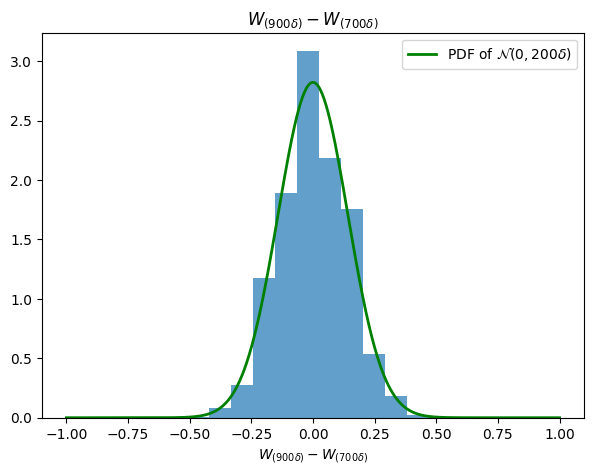

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

result = multiple_10000_w_t[900, :] - multiple_10000_w_t[700, :]

ax.hist(result, alpha=.7, density=True, bins=13)

x = np.linspace(-1, 1, 500)
var_200 = 200*delta
normal_function_200 = 1/(np.sqrt(var_200)*np.sqrt(2*np.pi))*np.exp(-x**2/(2*var_200))

ax.plot(x, normal_function_200, color="green", lw=2, label=r"PDF of $\mathcal{N}(0,  200\delta)$")

ax.set_xlabel(r"$ W_{(900\delta)} - W_{(700\delta)}$")
ax.set_title(r"$W_{(900\delta)} - W_{(700\delta)}$")
ax.legend()

plt.show()

We can see how the theoretical PDF of $\mathcal{N}(0, 200\delta)$ and the samples obtained from $W_{900\delta} - W_{700\delta}$ closely match. The reasoning behind this not-so-surprising coincidence lies in the fact that the random walk steps are generated *independently*, as we mentioned before. This characteristic can be proven using the Brownian motion approximation $W_t = \sum\limits_{k=1}^{n} X_k$ and calculating the mean and variance of the difference $W_{t_b} - W_{t_a}$. In general:

\begin{align}
W_{t_b} - W_{t_a} \sim \mathcal{N}(0, t_b - t_a) \quad \text{if}  \quad t_b > t_a
\end{align}

<a id="em"></a>
### C. Euler-Maruyama method

This section introduces the EM method for solving an SDE. As we will see, the EM method relies on the sample paths obtained from Brownian motion that we explained in the previous section. We fisrt introduce the EM approximation theory. After that, we illustrate the EM characteristics with a practical example.

Let us consider the following SDE:

\begin{align}
dX_{t} = \mu(X_t, t)dt + \sigma(X_t, t) dW_t.
\end{align}

We want to solve this SDE to obtain the continuous time-evolution of $X_t$ for $t_0 \leq t \leq T$ knowing the initial condition $X_{t_0} = X_{0}$. 

For certain types of SDEs in this form, so-called explicit SDEs, we can obtain their general solution in closed-form. How to obtain this closed-form solution is beyond the scope of this project. Later on, we will use a closed-form analytical expression to test the accuracy of the EM method. However, let us assume that we do not know the exact cotinuous solution of the SDE. If we want to approximate the solution of the SDE, we can resort to a numerical scheme that provides a time discrete approximation. Thanks to this discrete approximation, we can split the continuous time $t$ into small time steps to compute an approximated value of $X_t$. We will see the convergence and error incurred depending on the lenght of the time step taken.

The EM method is one of the simplest time discrete approximations for solving an SDE. We can generate an approximation of $X_t$ satisfying the SDE presented above applying the following steps of the EM method:

1. Consider the following discretisation of the time interval $[t_0, T]$:

\begin{align}
t_0 = \tau_{0} < \tau_{1} < \cdots < \tau_{n} < \cdots < \tau_{N} = T,
\end{align}

where $\delta = \tau_{n+1} - \tau_{n}$. Assuming equidistant discretisation times, so that $\tau_{n} = t_{0} + n \delta$, with $\delta = \frac{T-t_{0}}{N}$, being $N$ large enough so that $\delta \in (0, 1)$.


2. Define the iterative scheme:

\begin{align}
Y_{n+1} = Y_{n} + \mu(Y_n, \tau_n)(\tau_{n+1} - \tau_{n}) + \sigma(Y_{n}, \tau_{n})(W_{\tau_{n+1}} - W_{\tau_{n}}),
\end{align}

for $n= 0, 1, 2, \ldots, N - 1$ with initial value: $Y_{0} = X_{0}$.

The sequence $\{Y_{n}, n=0, 1, \ldots, N\}$ constitutes the EM approximation of $X_{t}$ at the instants of the time discretisation $\{\tau_n, n = 0, 1, \ldots, N\}$. Note that in the abscence of the stochastic term, that is neglecting the effect of $\sigma(X_t, t)dW_t$, we recover the [Euler scheme](https://en.wikipedia.org/wiki/Euler_method) for an ordinary differential equation of the form:

\begin{align}
\frac{dX_t}{dt} = \mu(X_t, t).
\end{align}

However, the stochastic term requires us to compute the random increments of the Brownian motion $W_{\tau_{n+1}} - W_{\tau_{n}}$. As we explained in the Brownian motion section:

\begin{align}
W_{\tau_{n+1}} - W_{\tau_{n}} \sim \mathcal{N}(0, \tau_{n+1} - \tau_{n}).
\end{align}

To accomplish this increments, we simply have to generate a sequence of random numbers coming from a normal distribution with mean 0 and variance equal to the defined time step difference $\delta = \tau_{n+1} - \tau_{n}$.

For the sake of clarity let us see how we can obtain one single path approximation for the following simple SDE:

\begin{align}
dX_t = 2t dt + 0.5 dW_t,
\end{align}

over $t \in [0, 2]$ with $X_{0} = 1$. In this example, $\mu(X_t, t) = 2t$ is a linear time-dependent function and $\sigma(X_t, t) = 0.5$ is a constant diffusion. Let us code it!

In [22]:
# Define the time discretisation
t_0 = 0
T = 2
N = 200
delta = (T-t_0)/N
steps = np.arange(0, N+1)
t = t_0 + steps*delta

# Set initial condition and pre-allocate Y sequence into an array
Y_0 = 1
Y = np.zeros(N+1)
Y[0] = Y_0

# define drift and diffusion coefficients
def get_drift(X: float, t: float) -> float:
    return 2*t

def get_diffusion(X: float, t: float) -> float:
    return 0.5

In [23]:
for n in steps[:-1]:  # Compute until N-1
    tau_n = t[n]  # get time step n
    Y_n = Y[n]  # get Y at n
    
    mu = get_drift(X=Y_n, t=tau_n)  # in this case, mu = 2*tau
    sigma = get_diffusion(X=Y_n, t=tau_n)  # in this case, sigma = 0.5
   
    # Compute Brownian increment, recall standard deviation = sqrt(variance)
    # in this case, variance = \tau_{n+1} - \tau_{n} = \delta 
    dW = np.random.normal(loc=0, scale=np.sqrt(delta))
    
    # Compute next step of the EM scheme
    Y[n+1] = Y_n + mu*delta + sigma*dW

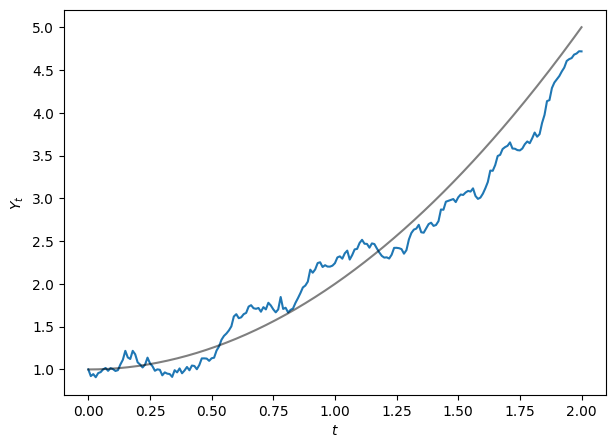

In [24]:
# Plot the random path obtained and the drift of the SDE
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, Y)
ax.plot(t, 1+t**2, color="black", alpha=0.5)

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$Y_t$")

plt.show()

This is really good! By carefully looking at the SDE mathematical expression, we know that the solution must start at $Y_0= 1$ and the drift should move the variable towards $Y_T \approx 5$ following $t^2$, which is the solution of the deterministic differential equation when we neglect the noise term. The obtained blue random walk deviates from the drift due to the noise generated by the Brownian motion. Of course, how much it deviates depends on the random numbers, so each sample will generate a different random path. Now, let us compute an ensemble of random paths to statistically assess the behaviour of our estimated solution $Y_t$.

In [25]:
# Define the number of samples
ns = 10_000

# Set intial condition and pre-allocate multiple Y sequence into an array
Y_0 = 1 * np.ones(ns)
Y = np.zeros((ns, N+1))
Y[:, 0] = Y_0

# Redefine drift and diffusion coefficients for consistency
# although in this simple case we could have reused the previous drift and diffusion
def get_multi_drift(X: np.ndarray, t: float) -> np.ndarray:
    return np.ones_like(X) * 2*t

def get_multi_diffusion(X: np.ndarray, t: float) -> np.ndarray:
    return np.ones_like(X) * 0.5

In [26]:
for n in steps[:-1]:  # Compute until N-1
    tau_n = t[n]  # get time step n
    Y_n = Y[:, n]  # get Y at n
    
    mu = get_multi_drift(X=Y_n, t=tau_n)  # in this case, mu = 2*tau
    sigma = get_multi_diffusion(X=Y_n, t=tau_n)  # in this case, sigma = 0.5
   
    # Compute ns Brownian increment
    dW = np.random.normal(loc=0, scale=np.sqrt(delta), size=ns)
    
    # Compute next step of the EM scheme
    Y[:, n+1] = Y_n + mu*delta + sigma*dW

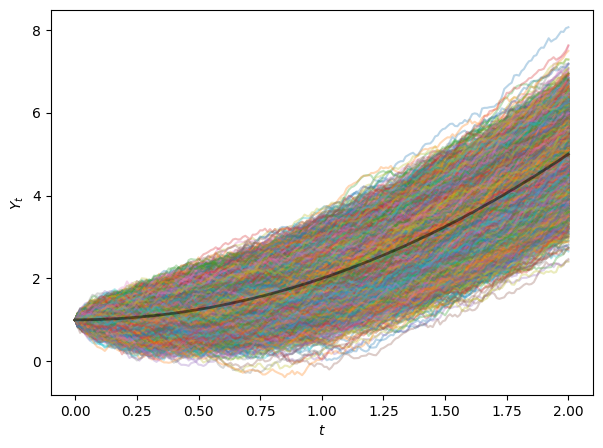

In [27]:
# Plot the results
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, Y.T, alpha=0.3)
ax.plot(t, 1+t**2, color="black", lw=2, alpha=0.5)

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$Y_t$")

plt.show()

Let us analyse the random walk distribution at different time steps. In particular, we assess $Y_{0.2}$, $Y_{1}$ and $Y_{2}$, which corresponds with $\tau_{20}, \tau_{100}$ and $\tau_{200}$. According to the basic Brownian motion theory, the drift imposed in the SDE and properties of Gaussian random distributions, the random walk samples should follow the following distribution:

\begin{align}
&Y_{0.2} \sim \mathcal{N}(1+(0.2)^2, 0.2 \cdot (0.5)^2) = \mathcal{N}(1.04, 0.05) \\
&Y_{1} \sim \mathcal{N}(1+(1)^2, 1 \cdot (0.5)^2) = \mathcal{N}(2, 0.25) \\
&Y_{2} \sim \mathcal{N}(1+(2)^2, 2 \cdot (0.5)^2) = \mathcal{N}(5, 0.5) \\
\end{align}

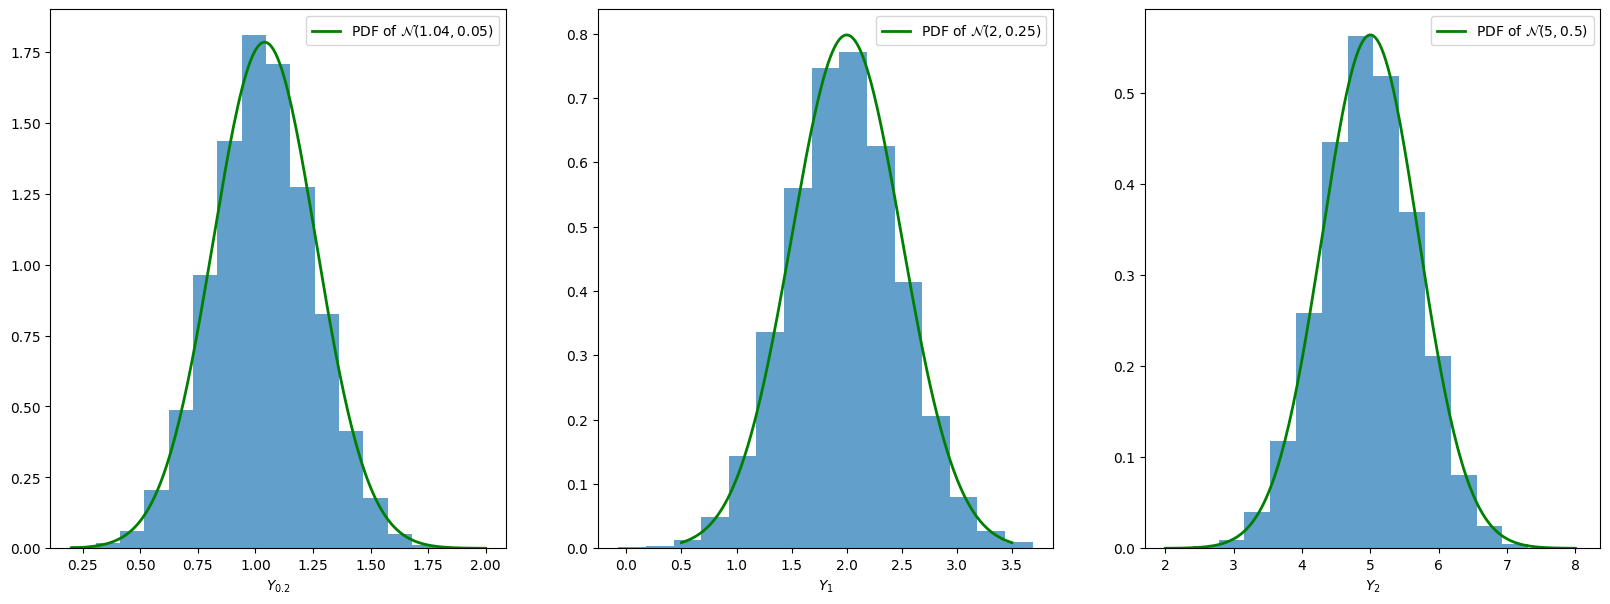

In [28]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 7))

Y_02 = Y[:, 20]
ax0.hist(Y_02, alpha=.7, density=True, bins=15)

x = np.linspace(0.2, 2, 200)
var_02 = 0.2 * 0.5**2
normal_function_02 = 1/np.sqrt(2*np.pi*var_02)*np.exp(-(x - 1.04)**2/(2*var_02))
ax0.plot(x, normal_function_02, color="green", lw=2, label=r"PDF of $\mathcal{N}(1.04,  0.05)$")
ax0.set_xlabel(r"$Y_{0.2}$")
ax0.legend()

Y_1 = Y[:, 100]
ax1.hist(Y_1, alpha=.7, density=True, bins=15)

x = np.linspace(0.5, 3.5, 200)
var_1 = 1 * 0.5**2
normal_function_1 = 1/np.sqrt(2*np.pi*var_1)*np.exp(-(x - 2)**2/(2*var_1))
ax1.plot(x, normal_function_1, color="green", lw=2, label=r"PDF of $\mathcal{N}(2,  0.25)$")
ax1.set_xlabel(r"$Y_{1}$")
ax1.legend()

Y_2 = Y[:, 200]
ax2.hist(Y_2, alpha=.7, density=True, bins=15)

x = np.linspace(2, 8, 200)
var_2 = 2 * 0.5**2
normal_function_2 = 1/np.sqrt(2*np.pi*var_2)*np.exp(-(x - 5)**2/(2*var_2))
ax2.plot(x, normal_function_2, color="green", lw=2, label=r"PDF of $\mathcal{N}(5,  0.5)$")
ax2.set_xlabel(r"$Y_{2}$")
ax2.legend()

plt.show()

Once we have seen the capabilites of the EM method for solving SDEs, let us discuss an important feature of the simulated paths obtained through the EM method. We shall consider the following SDE:

\begin{align}
dX_t = 1.5 X_t dt + 2X_t dW_t,
\end{align}

where both the drift and the diffusion coefficients are state-dependent functions. We want to solve this SDE for the time interval $t \in [0, 1]$ with $X_0 = 1$. For comparison purposes, we will consider the exact solution of this SDE given by:

\begin{align}
X_t = X_0 \exp \left(-0.5t + 2W_t \right).
\end{align}

As we commented at the beginning of this section, the technical details to obtain this exact closed-form solution is beyond the scope of this project. So, do not worry about how to obtain this analytical expression, let us take it for granted.

Our aim is to use the EM method with different time discretisations, i.e., different time-step lengths, to evaluate the approximation quality of the EM method.

First of all, we compute the exact solution with a specific sample path of the Brownian motion. To ensure accuracy, we use a high resolution discretisation, i.e., a large number of time steps with small length. We will store this Brownian path as we will use it for the different time discretisation analysis. By using the same sample path guarantees that the solutions across different time discretisations are reproducible and comparable.

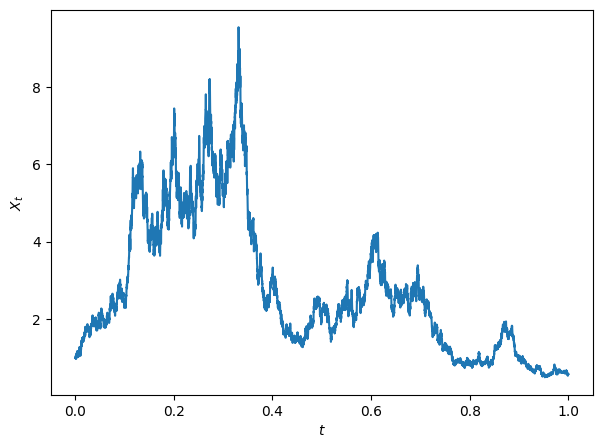

In [29]:
# Use a time step of 0.0001, equivalent to 10_000 steps from 0 to 1 for the exact solution
t_0 = 0
T = 1
N = 10_000
delta = (T-t_0)/N
steps = np.arange(0, N+1)
t = t_0 + steps*delta

# Compute a sample path of the Brownian motion with the same shape 
np.random.seed(140)
random_samples_t = np.random.normal(loc=0, scale=np.sqrt(delta), size=t.shape[0])
random_samples_t[0] = 0
w_t = np.cumsum(random_samples_t)

# Calculate the exact solution

exact_x_t = 1*np.exp(-0.5*t + 2*w_t) 

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, exact_x_t)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_t$")
plt.show()

In [30]:
# Define some useful functions
def compute_discretisation(t_0: float, T: float, N: int) -> (float, np.ndarray):
    delta = (T - t_0)/N
    steps = np.arange(0, N+1)
    return delta, steps

def get_t_and_w_t_from_high_res_t(t: np.ndarray, w_t:np.ndarray, N: int) -> (np.ndarray, np.ndarray):
    index_mask = np.linspace(0, t.shape[0]-1, num=N+1, dtype=int) # we pick N+1 equally spaced index from t
    t_ = t[index_mask]  # obtain the time instants
    w_t_ = w_t[index_mask]  # obtain the sample path values at t_
    return t_, w_t_

def allocate_Y(steps: np.ndarray, X_0: float) -> np.ndarray:
    Y = np.zeros_like(steps, dtype=float)
    Y[0] = X_0
    return Y

def get_drift(a: float, X: float, t: float) -> float:
    return a*X

def get_diffusion(b: float, X: float, t: float) -> float:
    return b*X

def compute_numerical_solution(steps: np.ndarray, delta: float, Y: np.ndarray, t: np.ndarray, w_t: np.ndarray):
    for n in steps[:-1]:  # Compute until N-1    
        tau_n = t[n]  # get time step n
        Y_n = Y[n]  # get Y at n

        mu = get_drift(a=1.5, X=Y_n, t=tau_n)
        sigma = get_diffusion(b=2, X=Y_n, t=tau_n)
        
        # Obtain the corresponding element from the Brownian path
        # Note that it must be the difference between the time steps to get ~N(0, delta)
        dW = w_t[n+1] - w_t[n] 

        # Compute next step of the EM scheme
        Y[n+1] = Y_n + mu*delta + sigma*dW
    
    return Y

Now, we compute the EM method considering 4 time steps in the interval $[0, 1]$, i.e., $N=4$. We employ the same sample path of the Brownian motion to make the EM approximation comparable to the exact solution. If we used a different sample path, we could not compare the EM approximation, since the approximated path would correspond to a different random trajectory of the original SDE.

In [31]:
# Compute scenario a with N=4
N_a = 4
delta_a, steps_a = compute_discretisation(t_0=0, T=1, N=N_a)
t_a, w_t_a = get_t_and_w_t_from_high_res_t(t=t, w_t=w_t, N=N_a)
Y_a = allocate_Y(steps=steps_a, X_0=1)
Y_a = compute_numerical_solution(steps=steps_a, delta=delta_a, Y=Y_a, t=t_a, w_t=w_t_a)

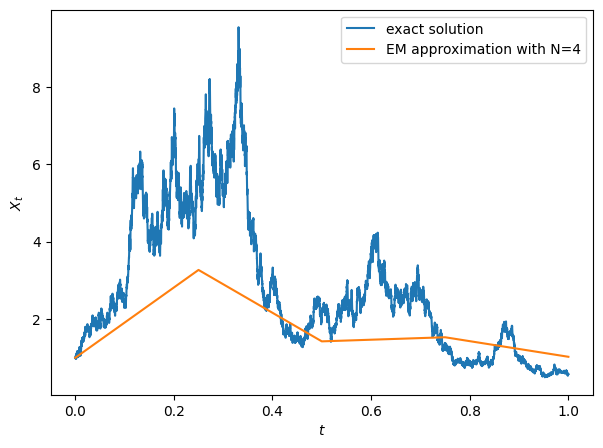

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, exact_x_t, label="exact solution")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_t$")

ax.plot(t_a, Y_a, label="EM approximation with N=4")

ax.legend()
plt.show()

We see the rough approximation generated by the EM method with $N=4 \, (\delta=0.25)$ compared to the exact solution generated by the same Brownian path. It is of no suprise that the EM approximation with $N=4$ significantly differs from the exact solution. However, we might expect a closer match using a smaller step size. 

Let us increase the resolution to evalutate the performance of the EM method.

In [33]:
# Compute scenarios:
# b -> N=8
# c -> N=100
# d -> N=500

N_b = 8
delta_b, steps_b = compute_discretisation(t_0=0, T=1, N=N_b)
t_b, w_t_b = get_t_and_w_t_from_high_res_t(t=t, w_t=w_t, N=N_b)
Y_b = allocate_Y(steps=steps_b, X_0=1)
Y_b = compute_numerical_solution(steps=steps_b, delta=delta_b, Y=Y_b, t=t_b, w_t=w_t_b)


N_c = 100
delta_c, steps_c = compute_discretisation(t_0=0, T=1, N=N_c)
t_c, w_t_c = get_t_and_w_t_from_high_res_t(t=t, w_t=w_t, N=N_c)
Y_c = allocate_Y(steps=steps_c, X_0=1)
Y_c = compute_numerical_solution(steps=steps_c, delta=delta_c, Y=Y_c, t=t_c, w_t=w_t_c)

N_d = 500
delta_d, steps_d = compute_discretisation(t_0=0, T=1, N=N_d)
t_d, w_t_d = get_t_and_w_t_from_high_res_t(t=t, w_t=w_t, N=N_d)
Y_d = allocate_Y(steps=steps_d, X_0=1)
Y_d = compute_numerical_solution(steps=steps_d, delta=delta_d, Y=Y_d, t=t_d, w_t=w_t_d)

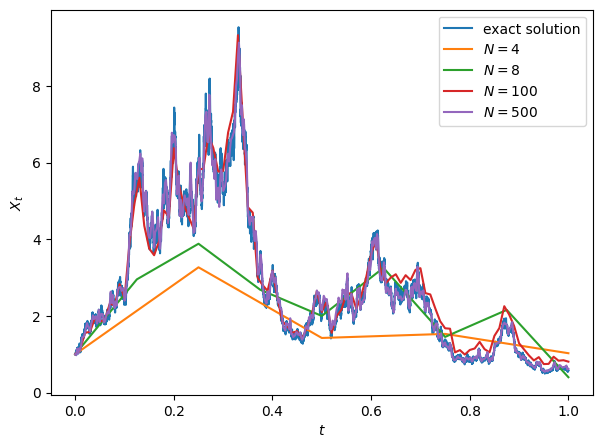

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, exact_x_t, label="exact solution")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_t$")

ax.plot(t_a, Y_a, label=r"$N=4$")
ax.plot(t_b, Y_b, label=r"$N=8$")
ax.plot(t_c, Y_c, label=r"$N=100$")
ax.plot(t_d, Y_d, label=r"$N=500$")

plt.legend()
plt.show()


By looking at this result, we can discern the sensitivity of the EM method to the resolution of the time step. A coarser time resolution (larger time step length) leads to a less precise estimation of the true solution of the SDE. Conversely, increasing the time resolution (reducing the time step length) produces a better approximation of the SDE. This example illustrate the potential of the EM method in approximating the true underlying solution of an SDE. It proves particularly useful in SDE setting where the drift and diffusion coefficient exhibit nonlinear or intricate forms that impede obtaining an analytical closed-from solution.

Through this time step resolution example, we have seen the numerous functions we must call to generate different approximations based on the number of steps parameter. Of course, we could wrap all functionalities into one single function. However, this solution still requires us to continuosly change the input parameters and call the function to obtain the estimated solution. To overcome this limitation we can resort to a Python class. 

As we will see in the following notebook, employing a class significnatly reduces the necessary boilerplate to play around with the EM method. Furthermore, the implemented class will allow us to customise the drift and diffusion terms to check the behaviour of different SDEs.